Column Names in Dataset:
['Timestamp', 'Species Name', 'Scientific Name[Eg:  Bengal Tiger – Panthera tigris tigris ]', 'Species Type', 'Conservation Status', 'Location (City/State/District)', 'Habitat Type', 'Activity Pattern', 'Feeding Behaviour', 'Mating Behaviour', 'Migration Pattern Changes', 'Social Interaction Changes', 'Stress Indicators (if measured, e.g., heart rate, hormone levels, etc.)', 'Mortality Rate (Deaths per observation period)']
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.67      0.57        12
           1       0.73      0.82      0.77        60
           2       0.57      0.38      0.45        32

    accuracy                           0.66       104
   macro avg       0.60      0.62      0.60       104
weighted avg       0.66      0.66      0.65       104

Overall Accuracy: 0.6635


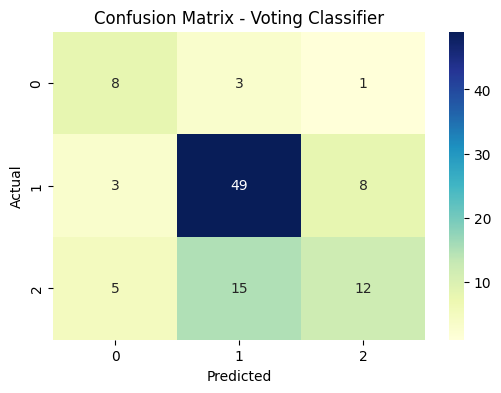


Accuracy per Species:
Insect: 0.8667
Reptile: 0.2500
Amphibian: 0.2857
Mammal: 0.5926
Bird: 0.8718


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier

# Load dataset
file_path = "/content/drive/MyDrive/Impact of 5G Electromagnetic Radiation on Animal Behaviour, Health, and Ecosystems .csv"
df = pd.read_csv(file_path)

# Strip whitespace from column names to avoid mismatches
df.columns = df.columns.str.strip()

# Print column names to verify them
print("Column Names in Dataset:")
print(df.columns.tolist())

# Define target and species columns (Update with correct names based on your dataset)
target_column = 'Activity Pattern'  # This is correct
species_column = 'Species Type'  # Changed to 'Species Type' as per your request

# Ensure that the target and species columns exist
if target_column not in df.columns or species_column not in df.columns:
    raise ValueError(f"Target column '{target_column}' or species column '{species_column}' not found.")

# Separate features and target
X = df.drop(columns=[target_column, species_column])  # Dropping 'Species Type' as it's not a feature
y = df[target_column]

# Encode target labels to numeric values (CatBoost requires numeric labels)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Identify column types
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(exclude=['number']).columns.tolist()

# Handle missing values
X[numerical_cols] = X[numerical_cols].apply(pd.to_numeric, errors='coerce')
X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].median())

X[categorical_cols] = X[categorical_cols].fillna(X[categorical_cols].mode().iloc[0])

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # Removed n_jobs
])

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test, sp_train, sp_test = train_test_split(
    X_processed, y_encoded, df[species_column], test_size=0.2, stratify=y_encoded, random_state=42
)

# Compute class weights for CatBoost
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = {class_label: weight for class_label, weight in zip(np.unique(y_encoded), class_weights)}

# Model definitions
catboost = CatBoostClassifier(verbose=0, random_state=42, class_weights=class_weight_dict)

# Simplified hyperparameter tuning (remove exhaustive grid search)
catboost.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

# Voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('cat', catboost),
        ('rf', RandomForestClassifier(n_estimators=150, class_weight='balanced', n_jobs=-1)),
        ('gb', GradientBoostingClassifier(n_estimators=150))
    ],
    voting='soft'
)
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix - Voting Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Accuracy per species (using 'Species Type' column for species-level accuracy)
species_accuracy = {}
sp_test_reset = sp_test.reset_index(drop=True)  # Reset index to match y_test and y_pred

for species in sp_test_reset.unique():
    idx = sp_test_reset[sp_test_reset == species].index
    correct = (y_test[idx] == y_pred[idx]).sum()  # Compare the true and predicted labels
    total = len(idx)
    species_accuracy[species] = correct / total

print("\nAccuracy per Species:")
for sp, acc in species_accuracy.items():
    print(f"{sp}: {acc:.4f}")
